Data Exploration

In [78]:
##########################################################################################
## 1 Data Description
##########################################################################################

#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import scipy
import matplotlib.pyplot as plt
import math
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import datawig
from scipy.stats import chisquare

#Import Data, store into data frame df_original
df_original = pd.read_csv('bank-full.csv',sep=";")

# Check top 5 attributes
df_original.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [79]:
# Summary of data frame
# 45211 entries, 17 features including 1 class feature
# Besides, all these 16 features are either categorical or integer types

df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [80]:
# checking NA data
missing_data = df_original.isnull().mean()*100

# 0.0 ,no missing data 
missing_data.sum()

# no empty/NA data exists, however, we will examine the "unknown" values in the following sections

0.0

In [81]:
##########################################################################################
## 2 Summary for categorical data
##########################################################################################
for column in df_original.select_dtypes(include='object').columns:
    df_original[column] = df_original[column].astype('category')
    print(column)
    print(df_original[column].unique())
    
def PrintDataframeCategoricalSummary(df):
    for column in df.dtypes[df.dtypes == 'category'].index:
        print(df[column].name, df[column].unique())
    
# Check categorical features with "unknown" value
for column in df_original.dtypes[df_original.dtypes == 'category'].index:
    num_of_unknown = df_original[column].str.contains('unknown').sum()
    print(df_original[column].name, 'unknown: ', num_of_unknown)
    
# we can see that job, education, contact and poutcome these four features have unknow values
# we will deal with the unknown data handling in the following sections

job
[management, technician, entrepreneur, blue-collar, unknown, ..., services, self-employed, unemployed, housemaid, student]
Length: 12
Categories (12, object): [management, technician, entrepreneur, blue-collar, ..., self-employed, unemployed, housemaid, student]
marital
[married, single, divorced]
Categories (3, object): [married, single, divorced]
education
[tertiary, secondary, unknown, primary]
Categories (4, object): [tertiary, secondary, unknown, primary]
default
[no, yes]
Categories (2, object): [no, yes]
housing
[yes, no]
Categories (2, object): [yes, no]
loan
[no, yes]
Categories (2, object): [no, yes]
contact
[unknown, cellular, telephone]
Categories (3, object): [unknown, cellular, telephone]
month
[may, jun, jul, aug, oct, ..., jan, feb, mar, apr, sep]
Length: 12
Categories (12, object): [may, jun, jul, aug, ..., feb, mar, apr, sep]
poutcome
[unknown, failure, other, success]
Categories (4, object): [unknown, failure, other, success]
y
[no, yes]
Categories (2, object): [

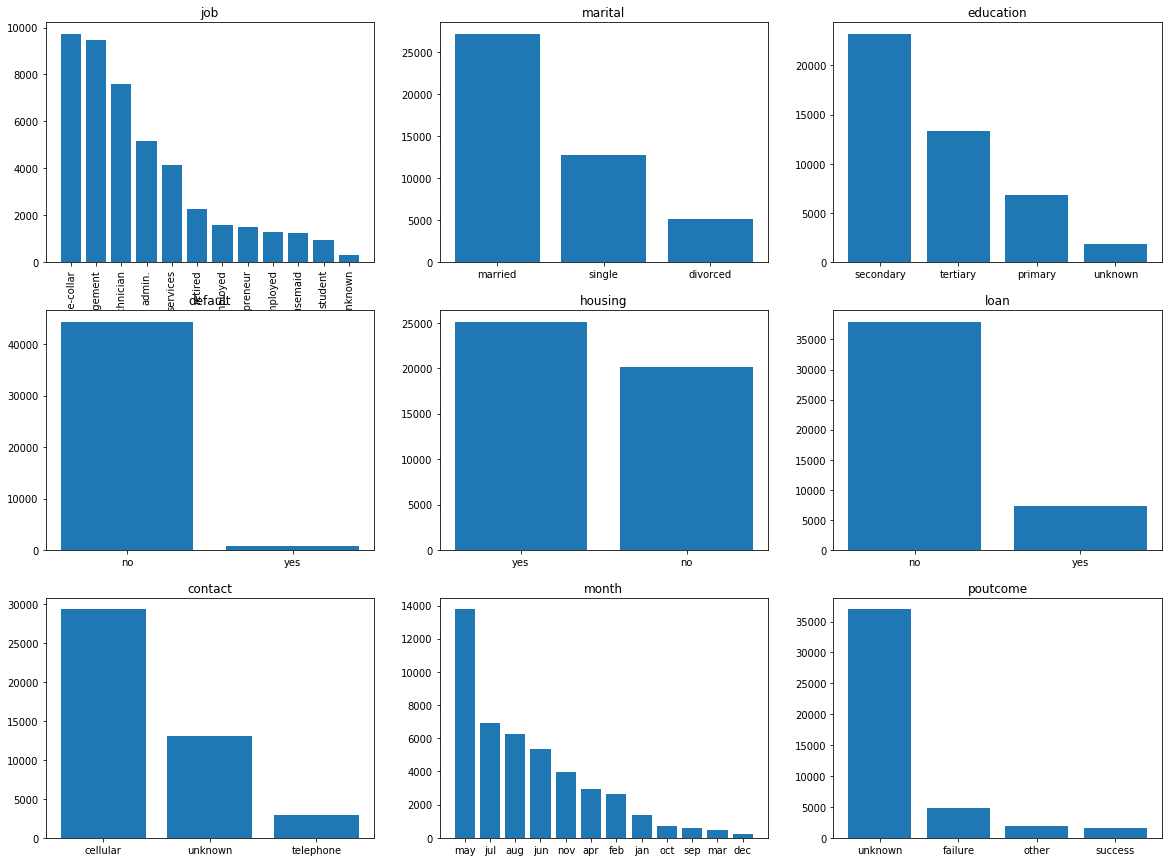

In [82]:
##########################################################################################
## 3. Categorical Attributes Exploration
##########################################################################################

# only for categorical data and excluding class feature
cat_columns = df_original.columns[df_original.dtypes == 'category']
cat_columns = cat_columns.drop(['y'])

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for column in cat_columns:
    value_counts = df_original[column].value_counts()
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    axs[trace_x, trace_y].set_title(column)
    
    for tick in axs[0, 0].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

#For now,nothing Special for the categorical attributes, we will engineer these features one by one in the following section

In [83]:
##########################################################################################
## 4. Summary for continous data
##########################################################################################
df_original.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


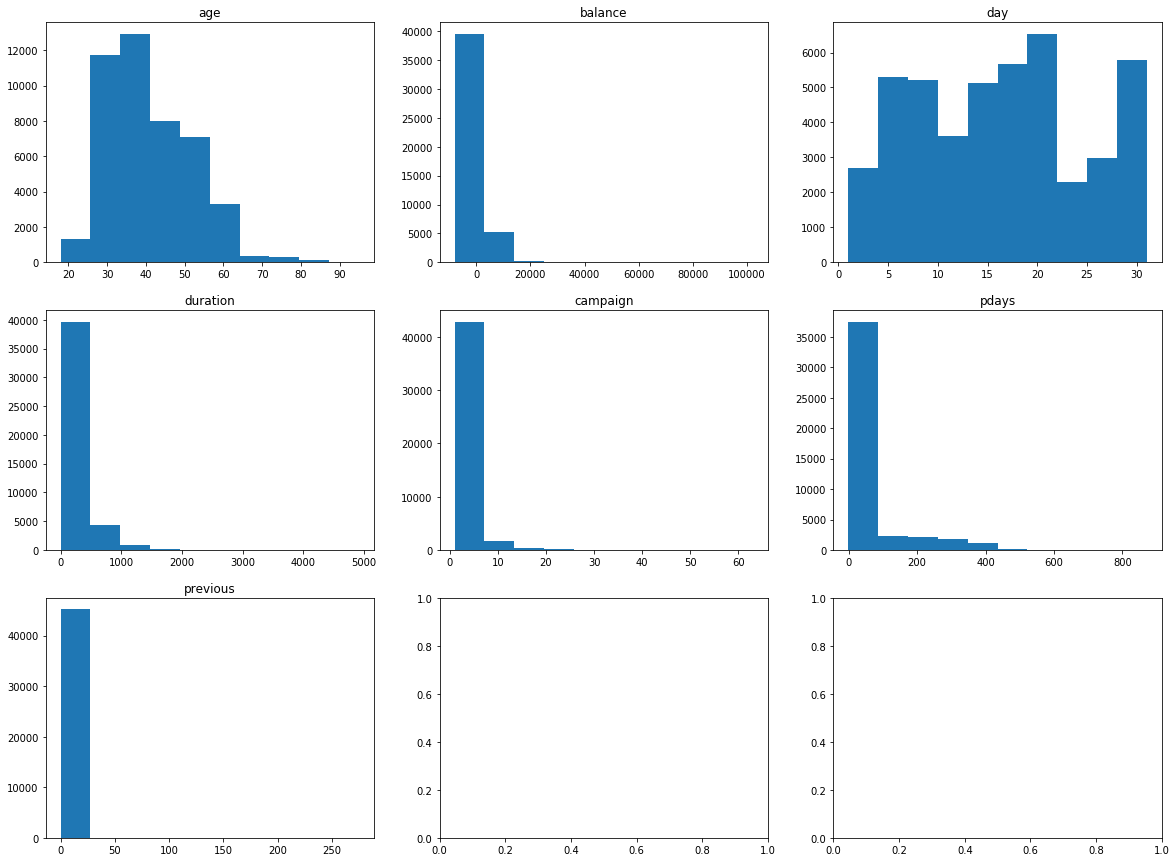

In [84]:
##########################################################################################
## 5. Continous Attributes Exploration
##########################################################################################
def NumericalHistPlot(df):
    num_columns = df.columns[~(df.dtypes == 'category')]

    fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

    counter = 0
    for num_column in num_columns:
        trace_x = counter // 3
        trace_y = counter % 3
    
        axs[trace_x, trace_y].hist(df[num_column])
        axs[trace_x, trace_y].set_title(num_column)
    
        counter += 1
        
    plt.show()

NumericalHistPlot(df_original)

#zoom in the graphs, we noticed that previous and campagin seems have outliers. we will handling the outliers 
#in following sections

In [85]:
##########################################################################################
## 6. Categorical: Feature Engineering(Details using Tableau)
##########################################################################################




# poutcome has 36959 out of 45211 unknown values, we decide to drop the feature
df_clean = df_original.drop(columns=['poutcome'], errors='ignore')

# we are mainly concerned with the number of job categories provided and observe that some of simply duplicate 
# or there are overlaps among different job categories by common sense
for jobcat in df_original.job.unique():
    print (jobcat)
    
## management
## technician
## entrepreneur
## retired
## admin.
## services
## blue-collar
## self-employed
## unemployed
## housemaid
## student


# merge entrepreneur into self_employed 
df_clean.job.replace(['entrepreneur', 'self-employed'], 'self-employed', inplace=True)

# merge admin. into management
df_clean.job.replace(['admin.', 'management'], 'management', inplace=True)

# merge technician into blue-collar
df_clean.job.replace(['blue-collar', 'technician'], 'blue-collar', inplace=True)

# merge housemaid into services
df_clean.job.replace(['services', 'housemaid'], 'services', inplace=True)

    
# after the merging, we have reduced the number of job categories to 7
#for jobcat in df_clean.job.unique():
#    print (jobcat)
    
PrintDataframeCategoricalSummary(df_clean)

## management
## blue-collar
## self-employed
## unemployed
## retired
## services
## student

management
technician
entrepreneur
blue-collar
unknown
retired
admin.
services
self-employed
unemployed
housemaid
student
job [management, blue-collar, self-employed, unknown, retired, services, unemployed, student]
Categories (8, object): [management, blue-collar, self-employed, unknown, retired, services, unemployed, student]
marital [married, single, divorced]
Categories (3, object): [married, single, divorced]
education [tertiary, secondary, unknown, primary]
Categories (4, object): [tertiary, secondary, unknown, primary]
default [no, yes]
Categories (2, object): [no, yes]
housing [yes, no]
Categories (2, object): [yes, no]
loan [no, yes]
Categories (2, object): [no, yes]
contact [unknown, cellular, telephone]
Categories (3, object): [unknown, cellular, telephone]
month [may, jun, jul, aug, oct, ..., jan, feb, mar, apr, sep]
Length: 12
Categories (12, object): [may, jun, jul, aug, ..., feb, mar, apr, sep]
y [no, yes]
Categories (2, object): [no, yes]


               age   balance       day  duration  campaign     pdays  previous
age       1.000000  0.097783 -0.009120 -0.004648  0.004760 -0.023758  0.001288
balance   0.097783  1.000000  0.004503  0.021560 -0.014578  0.003435  0.016674
day      -0.009120  0.004503  1.000000 -0.030206  0.162490 -0.093044 -0.051710
duration -0.004648  0.021560 -0.030206  1.000000 -0.084570 -0.001565  0.001203
campaign  0.004760 -0.014578  0.162490 -0.084570  1.000000 -0.088628 -0.032855
pdays    -0.023758  0.003435 -0.093044 -0.001565 -0.088628  1.000000  0.454820
previous  0.001288  0.016674 -0.051710  0.001203 -0.032855  0.454820  1.000000


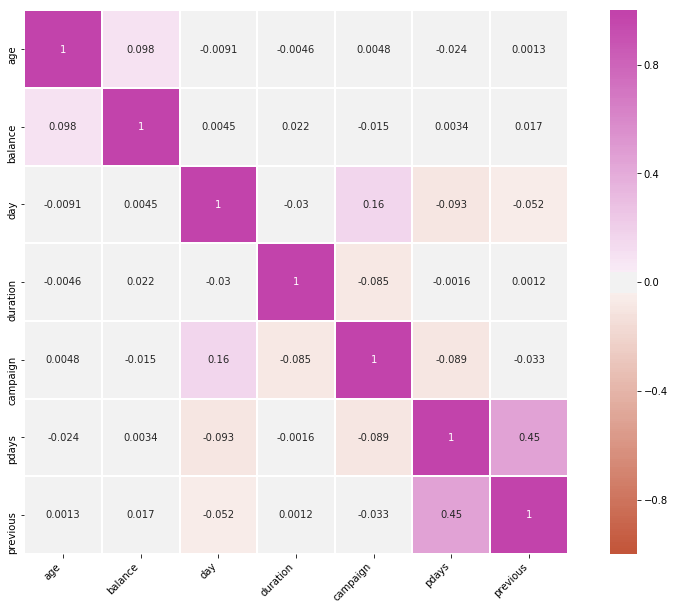

In [86]:
##########################################################################################
## 7. Numberical/Continuous: Feature Engineering(Details using Tableau)
##########################################################################################

# numerical correlation matrix among numerical features
correlations = df_clean.corr()

print(correlations)

plt.figure(figsize=(15,10)) 

ax = sns.heatmap(
    correlations, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 320, n=200),
    square=True,
    linewidths=1,
    annot=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


In [87]:
##########################################################################################
## 7. Numberical/Continuous: Feature Engineering(Details using Tableau) Cont.
##########################################################################################

## for these 7 numercial featuers, we have done the following modifications
## a) new categorical feature balanceGroup from balance feature, and balance will be removed

## creation of categorical balanceGroup and removal of balance
df_clean.loc[df_clean['balance'] < 0,'balanceGroup'] = 'negative'
df_clean.loc[(df_clean['balance'] >= 0) & (df_clean['balance'] < 1000),'balanceGroup'] = 'low'
df_clean.loc[(df_clean['balance'] >= 1000) & (df_clean['balance'] < 5000),'balanceGroup'] = 'medium'
df_clean.loc[df_clean['balance'] >= 5000,'balanceGroup'] = 'high'
df_clean['balanceGroup'] = df_clean['balanceGroup'].astype('category')
df_clean = df_clean.drop(columns=['balance'], errors='ignore')


PrintDataframeCategoricalSummary(df_clean)


job [management, blue-collar, self-employed, unknown, retired, services, unemployed, student]
Categories (8, object): [management, blue-collar, self-employed, unknown, retired, services, unemployed, student]
marital [married, single, divorced]
Categories (3, object): [married, single, divorced]
education [tertiary, secondary, unknown, primary]
Categories (4, object): [tertiary, secondary, unknown, primary]
default [no, yes]
Categories (2, object): [no, yes]
housing [yes, no]
Categories (2, object): [yes, no]
loan [no, yes]
Categories (2, object): [no, yes]
contact [unknown, cellular, telephone]
Categories (3, object): [unknown, cellular, telephone]
month [may, jun, jul, aug, oct, ..., jan, feb, mar, apr, sep]
Length: 12
Categories (12, object): [may, jun, jul, aug, ..., feb, mar, apr, sep]
y [no, yes]
Categories (2, object): [no, yes]
balanceGroup [medium, low, negative, high]
Categories (4, object): [medium, low, negative, high]


In [88]:
##########################################################################################
## 8. Missing Data Handling
##########################################################################################
from scipy.stats import chisquare

# Education Imputation
#         y       n
# known   5037    38317
# unkown  252     1605

known = df_clean[(df_clean['education'] != "unknown")]
unknown = df_clean[(df_clean['education'] == "unknown")]

# print(known['y'].value_counts(),unknown['y'].value_counts())

matrics = [ [ len(known[known['y']=='yes']), len(known[known['y']=='no'])], 
       [ len(unknown[unknown['y']=='yes']), len(unknown[unknown['y']=='no']) ] ]
chi2, p, ddof, expected = scipy.stats.chi2_contingency( matrics )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )
print( expected )
# Based on Chi-Squared distribution table, p-value =0.01, 
# hence the unknown status is related to our target response.

Test Statistic: 6.38058198299012
p-value: 0.011537559276897627
Degrees of Freedom: 1

[[ 5071.75921789 38282.24078211]
 [  217.24078211  1639.75921789]]


In [89]:
# Job Imputation
#           y       n
# known     5255    39668
# unknown   34      254

known = df_clean[(df_clean['job'] != "unknown")]
unknown = df_clean[(df_clean['job'] == "unknown")]

# print(known['y'].value_counts(),unknown['y'].value_counts())

matrics = [ [ len(known[known['y']=='yes']), len(known[known['y']=='no'])], 
       [ len(unknown[unknown['y']=='yes']), len(unknown[unknown['y']=='no']) ] ]
chi2, p, ddof, expected = scipy.stats.chi2_contingency( matrics )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )
print( expected )

# Based on Chi-Squared distribution table, The Statistic = 0.001, 
# hence the unknown status is not related to our target response.

Test Statistic: 0.0012421778371059784
p-value: 0.9718847438072241
Degrees of Freedom: 1

[[5.25530838e+03 3.96676916e+04]
 [3.36916237e+01 2.54308376e+02]]


In [90]:
# Contact Imputation
#           y       n
# known     4759    27432
# unknown   530      12490

known = df_clean[(df_clean['contact'] != "unknown")]
unknown = df_clean[(df_clean['contact'] == "unknown")]

# print(known['y'].value_counts(),unknown['y'].value_counts())
matrics = [ [ len(known[known['y']=='yes']), len(known[known['y']=='no'])], 
       [ len(unknown[unknown['y']=='yes']), len(unknown[unknown['y']=='no']) ] ]
chi2, p, ddof, expected = scipy.stats.chi2_contingency( matrics )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )
print( expected )

# Based on Chi-Squared distribution table, The Statistic = 1028.93, 
# hence the unknown status is related to our target response.

Test Statistic: 1028.9314916038188
p-value: 9.24040995646625e-226
Degrees of Freedom: 1

[[ 3765.85784433 28425.14215567]
 [ 1523.14215567 11496.85784433]]


In [91]:
# Drop Job with 'unknown'
df_clean.drop(df_clean[df_clean['job'] == "unknown"].index , inplace=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44923 entries, 0 to 45210
Data columns (total 16 columns):
age             44923 non-null int64
job             44923 non-null category
marital         44923 non-null category
education       44923 non-null category
default         44923 non-null category
housing         44923 non-null category
loan            44923 non-null category
contact         44923 non-null category
day             44923 non-null int64
month           44923 non-null category
duration        44923 non-null int64
campaign        44923 non-null int64
pdays           44923 non-null int64
previous        44923 non-null int64
y               44923 non-null category
balanceGroup    44923 non-null category
dtypes: category(10), int64(6)
memory usage: 2.8 MB


In [92]:
#　Dealling with Outliers

from collections import Counter

def detect_outliers(df, n, features):

    outlier_indices = []

    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)

        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

Outliers_to_drop = detect_outliers(df_clean, 2, ["pdays", "previous", "campaign"])

In [93]:
# Drop outlier records from the result
df_clean = df_clean.copy().drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [94]:
# Patch unknown data from 'education' and 'contact' by using 'most_frequent'
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values="unknown",strategy="most_frequent")
df_clean["education"]=imp.fit_transform(df_clean[["education"]])
df_clean["contact"]=imp.fit_transform(df_clean[["contact"]])

In [95]:
#Check the education result after imputation
df_clean["education"].value_counts()

secondary    24728
tertiary     13202
primary       6784
Name: education, dtype: int64

In [96]:
#Check the contact result after imputation
df_clean["contact"].value_counts()

cellular     41890
telephone     2824
Name: contact, dtype: int64

In [97]:
##########################################################################################
## 9.Data Normalization
##########################################################################################

## 1.Job Normalization
# to map each categorical value to a numeric value
labels = df_clean['job'].astype('category').cat.categories.tolist()
# ['admin.',
#  'blue-collar',
#  'entrepreneur',
#  'housemaid',
#  'management',
#  'retired',
#  'self-employed',
#  'services',
#  'student',
#  'technician',
#  'unemployed',
#  'unknown']
replace_map_comp = {'job' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
# {'job': {'admin.': 1,
#   'blue-collar': 2,
#   'entrepreneur': 3,
#   'housemaid': 4,
#   'management': 5,
#   'retired': 6,
#   'self-employed': 7,
#   'services': 8,
#   'student': 9,
#   'technician': 10,
#   'unemployed': 11,
#   'unknown': 12}}
df_clean.replace(replace_map_comp, inplace=True)
# data.info()

df_clean.head()

,age,job,marital,education,default,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,balanceGroup
0,58,5,married,tertiary,no,yes,no,cellular,5,may,261,1,-1,0,no,medium
1,44,2,single,secondary,no,yes,no,cellular,5,may,151,1,-1,0,no,low
2,33,7,married,secondary,no,yes,yes,cellular,5,may,76,1,-1,0,no,low
3,47,2,married,secondary,no,yes,no,cellular,5,may,92,1,-1,0,no,medium
4,35,5,married,tertiary,no,yes,no,cellular,5,may,139,1,-1,0,no,low


In [98]:
## 2.Marital Normalization
replace_map_comp = {'marital': {'divorced': 0, 'single': 1, 'married': 2}}
df_clean.replace(replace_map_comp, inplace=True)
# data.info()

df_clean.head()

,age,job,marital,education,default,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,balanceGroup
0,58,5,2,tertiary,no,yes,no,cellular,5,may,261,1,-1,0,no,medium
1,44,2,1,secondary,no,yes,no,cellular,5,may,151,1,-1,0,no,low
2,33,7,2,secondary,no,yes,yes,cellular,5,may,76,1,-1,0,no,low
3,47,2,2,secondary,no,yes,no,cellular,5,may,92,1,-1,0,no,medium
4,35,5,2,tertiary,no,yes,no,cellular,5,may,139,1,-1,0,no,low


In [99]:
## 3.Education Normalization
replace_map_comp = {'education': {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}}
df_clean.replace(replace_map_comp, inplace=True)
# # data.info()

df_clean.head()

,age,job,marital,education,default,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,balanceGroup
0,58,5,2,3,no,yes,no,cellular,5,may,261,1,-1,0,no,medium
1,44,2,1,2,no,yes,no,cellular,5,may,151,1,-1,0,no,low
2,33,7,2,2,no,yes,yes,cellular,5,may,76,1,-1,0,no,low
3,47,2,2,2,no,yes,no,cellular,5,may,92,1,-1,0,no,medium
4,35,5,2,3,no,yes,no,cellular,5,may,139,1,-1,0,no,low


In [100]:
## 4.Default Normalization
replace_map_comp = {'default': {'no': 0, 'yes': 1}}
df_clean.replace(replace_map_comp, inplace=True)
## data.info()

df_clean.head()

,age,job,marital,education,default,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,balanceGroup
0,58,5,2,3,0,yes,no,cellular,5,may,261,1,-1,0,no,medium
1,44,2,1,2,0,yes,no,cellular,5,may,151,1,-1,0,no,low
2,33,7,2,2,0,yes,yes,cellular,5,may,76,1,-1,0,no,low
3,47,2,2,2,0,yes,no,cellular,5,may,92,1,-1,0,no,medium
4,35,5,2,3,0,yes,no,cellular,5,may,139,1,-1,0,no,low


In [101]:
## 5.Housing Normalization
replace_map_comp = {'housing': {'no': 0, 'yes': 1}}
df_clean.replace(replace_map_comp, inplace=True)
# # data.info()

df_clean.head()

,age,job,marital,education,default,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,balanceGroup
0,58,5,2,3,0,1,no,cellular,5,may,261,1,-1,0,no,medium
1,44,2,1,2,0,1,no,cellular,5,may,151,1,-1,0,no,low
2,33,7,2,2,0,1,yes,cellular,5,may,76,1,-1,0,no,low
3,47,2,2,2,0,1,no,cellular,5,may,92,1,-1,0,no,medium
4,35,5,2,3,0,1,no,cellular,5,may,139,1,-1,0,no,low


In [102]:
## 6.Loan Normalization
replace_map_comp = {'loan': {'no': 0, 'yes': 1}}
df_clean.replace(replace_map_comp, inplace=True)
# # data.info()

df_clean.head()

,age,job,marital,education,default,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,balanceGroup
0,58,5,2,3,0,1,0,cellular,5,may,261,1,-1,0,no,medium
1,44,2,1,2,0,1,0,cellular,5,may,151,1,-1,0,no,low
2,33,7,2,2,0,1,1,cellular,5,may,76,1,-1,0,no,low
3,47,2,2,2,0,1,0,cellular,5,may,92,1,-1,0,no,medium
4,35,5,2,3,0,1,0,cellular,5,may,139,1,-1,0,no,low


In [103]:
## 7. Contact Normalization
replace_map_comp = {'contact': {'unknown': 0, 'telephone': 1, 'cellular': 2}}
df_clean.replace(replace_map_comp, inplace=True)
# # data.info()

df_clean.head()

,age,job,marital,education,default,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,balanceGroup
0,58,5,2,3,0,1,0,2,5,may,261,1,-1,0,no,medium
1,44,2,1,2,0,1,0,2,5,may,151,1,-1,0,no,low
2,33,7,2,2,0,1,1,2,5,may,76,1,-1,0,no,low
3,47,2,2,2,0,1,0,2,5,may,92,1,-1,0,no,medium
4,35,5,2,3,0,1,0,2,5,may,139,1,-1,0,no,low


In [104]:
## 8. Month Normalization
replace_map_comp = {'month': {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}}
df_clean.replace(replace_map_comp, inplace=True)
# # data.info()

df_clean.head()

,age,job,marital,education,default,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,balanceGroup
0,58,5,2,3,0,1,0,2,5,5,261,1,-1,0,no,medium
1,44,2,1,2,0,1,0,2,5,5,151,1,-1,0,no,low
2,33,7,2,2,0,1,1,2,5,5,76,1,-1,0,no,low
3,47,2,2,2,0,1,0,2,5,5,92,1,-1,0,no,medium
4,35,5,2,3,0,1,0,2,5,5,139,1,-1,0,no,low


In [105]:
## 9. BalanceGroup Normalization
replace_map_comp = {'balanceGroup': {'negative': 0, 'low': 1, 'medium': 2, 'high': 3}}
df_clean.replace(replace_map_comp, inplace=True)
# # data.info()

df_clean.head()

,age,job,marital,education,default,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,balanceGroup
0,58,5,2,3,0,1,0,2,5,5,261,1,-1,0,no,2
1,44,2,1,2,0,1,0,2,5,5,151,1,-1,0,no,1
2,33,7,2,2,0,1,1,2,5,5,76,1,-1,0,no,1
3,47,2,2,2,0,1,0,2,5,5,92,1,-1,0,no,2
4,35,5,2,3,0,1,0,2,5,5,139,1,-1,0,no,1


In [106]:
##########################################################################################
## 9.Imbalance Data Handling 
##########################################################################################
# Class count
count_class_0, count_class_1 = df_clean['y'].value_counts()
count_class_0, count_class_1

(39472, 5242)

In [107]:
# The responses in the data are 90% “no” and 10% “yes”, which is surly a significantly imbalanced dataset.
# Procced to Resampling

# Divide by class
df_class_0 = df_clean[df_clean['y'] == 'no']
df_class_1 = df_clean[df_clean['y'] == 'yes']

In [108]:
#### Random Under-sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

In [109]:
print('Random under-sampling:')
print(df_test_under['y'].value_counts())

Random under-sampling:
yes    5242
no     5242
Name: y, dtype: int64


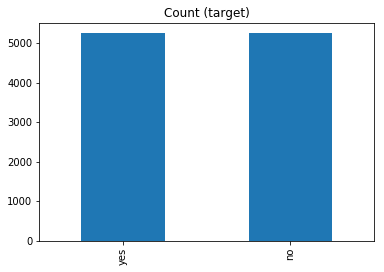

In [110]:
df_test_under['y'].value_counts().plot(kind='bar', title='Count (target)');

In [116]:
########Seperate Data to Training and Testing 
from sklearn.model_selection import train_test_split

#seperate data, get training and testing data 
data_under = df_test_under.drop('y', axis=1)
labels_under = df_test_under["y"].copy()
train, test, train_labels, test_labels = train_test_split(data_under, labels_under, test_size=0.2, random_state=1337)
# checking training data
len(labels_under)
# train.head()

10484

In [117]:
##########################################################################################
## 11.Modelling 
##########################################################################################

# ********************************************** RANDOM FOREST ****************************************************************
# ********************************************** RANDOM FOREST ****************************************************************
# ********************************************** RANDOM FOREST ****************************************************************
# ********************************************** RANDOM FOREST ****************************************************************
# ********************************************** RANDOM FOREST ****************************************************************

## 1.RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

## Ramdom FOREST Model
clf = RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

In [121]:
from sklearn.model_selection import GridSearchCV
## 5 Fold cross validation to get the best model 

###Compute grid search to find best paramters for pipeline
tuned_parameter = [{'max_depth':range(3,7), 'n_estimators':[50,100,200,300]}]
grid_search = GridSearchCV(clf, param_grid=tuned_parameter, cv=5).fit(train, train_labels)

grid_search.best_score_

0.8260403004650053

In [119]:
from sklearn.model_selection import cross_val_score

print ('on train set after resampling')
scores = cross_val_score(grid_search.best_estimator_, train, train_labels,cv=5,scoring='accuracy')
print (scores.mean(),scores)

on train set after resampling
0.8260412136660618 [0.83373063 0.82717521 0.81227652 0.82826476 0.82875895]


In [122]:
## Predication On Testig Data

# To Use the best estimator to predict Test Set after Sampling
print(classification_report(test_labels, grid_search.best_estimator_.predict(test)))

              precision    recall  f1-score   support

          no       0.84      0.80      0.82      1034
         yes       0.81      0.85      0.83      1063

    accuracy                           0.82      2097
   macro avg       0.83      0.82      0.82      2097
weighted avg       0.83      0.82      0.82      2097



In [43]:
#### Confusion Matrix 
test_pred = grid_search.best_estimator_.predict(test)
confusion_matrix(test_labels, test_pred)

array([[1667,  430],
       [ 298, 1799]])

In [44]:
#### Accuracy
from sklearn.metrics import accuracy_score,f1_score
accuracy_score(test_labels, test_pred)

0.8264186933714831

In [45]:
### Classification Report
print ('Classification Report:\n', classification_report(test_labels, test_pred))

Classification Report:
               precision    recall  f1-score   support

          no       0.85      0.79      0.82      2097
         yes       0.81      0.86      0.83      2097

    accuracy                           0.83      4194
   macro avg       0.83      0.83      0.83      4194
weighted avg       0.83      0.83      0.83      4194



In [46]:
### F1
print ('F1 score:', f1_score(test_labels, test_pred,average="macro"))

F1 score: 0.8262465761282642


In [47]:
### MCC
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_labels, test_pred)
mcc

0.6541346227293938

In [48]:
# ********************************************** KNN ****************************************************************
# ********************************************** KNN ****************************************************************
# ********************************************** KNN ****************************************************************
# ********************************************** KNN ****************************************************************
# ********************************************** KNN ****************************************************************

## 2. KNN
from sklearn.neighbors import KNeighborsClassifier
#Neighbors
clf = KNeighborsClassifier(n_neighbors =25, weights='uniform', p=2, metric='euclidean')

In [49]:
###Compute grid search to find best paramters for pipeline
tuned_parameter = [{'n_neighbors':[10,20,30,40,50]}]

grid_search = GridSearchCV(clf, param_grid=tuned_parameter, cv=5).fit(train, train_labels)
grid_search.best_score_, grid_search.best_params_

(0.7734499205087441, {'n_neighbors': 50})

In [50]:
### Predication On Testig Data
### Confusion Matrix
test_pred = grid_search.best_estimator_.predict(test)
confusion_matrix(test_labels, test_pred)

array([[1771,  326],
       [ 600, 1497]])

In [51]:
### Accuracy
from sklearn.metrics import accuracy_score,f1_score
accuracy_score(test_labels, test_pred)

0.7792083929422985

In [52]:
### Classification Report
print ('Classification Report:\n', classification_report(test_labels, test_pred))

Classification Report:
               precision    recall  f1-score   support

          no       0.75      0.84      0.79      2097
         yes       0.82      0.71      0.76      2097

    accuracy                           0.78      4194
   macro avg       0.78      0.78      0.78      4194
weighted avg       0.78      0.78      0.78      4194



In [53]:
### F1
print ('F1 score:', f1_score(test_labels, test_pred,average="macro"))

F1 score: 0.7782619717537866


In [54]:
### MCC
mcc = matthews_corrcoef(test_labels, test_pred)
mcc

0.5632455688708015

In [126]:
## LogisticRegression Model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import matthews_corrcoef, roc_curve, roc_auc_score, auc, accuracy_score, confusion_matrix, classification_report

import collections

def Run_LogisticRegression(train_x, train_y):
    five_fold = KFold(n_splits=5, random_state=seed)
    
    params=[{'penalty':['l1','l2']}]
    
    logitRegression = GridSearchCV(LogisticRegression(tol=1e-4), params, cv=5)
    gscv_lr = logitRegression.fit(train, train_labels)
   
    # [TODO] check later on the roc_auc_score
    myscore = cross_val_score(gscv_lr.best_estimator_, train_x, train_y, cv=five_fold, scoring='accuracy')
    print(myscore)
    
    pred = logitRegression.predict(test)
    print(accuracy_score(test_labels, pred))
    print(confusion_matrix(test_labels, pred))
    print(matthews_corrcoef(test_labels, pred))

In [127]:
Run_LogisticRegression(train, train_labels)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[0.7932062  0.80929678 0.78771616 0.79367919 0.77996422]
0.7849308536003815
[[836 198]
 [253 810]]
0.5708764741283732


In [136]:
## Neural Network Model
from sklearn.neural_network import MLPClassifier

def Run_NeuralNetwork(train_x, train_y):
    
    five_fold = KFold(n_splits=5, random_state=seed)
    
    params = {'solver': ['lbfgs'], 'max_iter': [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000 ], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(2, 10), 'random_state':[0,1,2,3,4,5,6,7,8,9]}
    nn_clf = GridSearchCV(MLPClassifier(), params)
    gscv_nn_clf = nn_clf.fit(train_x, train_y)

    myscore = cross_val_score(gscv_nn_clf.best_estimator_, train_x, train_y, cv=five_fold, scoring='accuracy')
    print(myscore)
    
    pred = nn_clf.predict(test)
    print(accuracy_score(test_labels, pred))
    print(confusion_matrix(test_labels, pred))
    print(matthews_corrcoef(test_labels, pred))

In [ ]:
Run_NeuralNetwork(train, train_labels)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
